In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# --- Parameters ---
n_qubits = 7
# num = input("Enter Number")
num: int = 58
target_bin = format(int(num), f'0{n_qubits}b')


# Oracle that marks |1001001⟩
def grover_oracle():
    qc = QuantumCircuit(n_qubits)

    # Flip bits where target has 0
    for i, bit in enumerate(reversed(target_bin)):
        if bit == '0':
            qc.x(i)

    # Multi-controlled Z via H + multi-controlled Toffoli
    qc.h(n_qubits - 1)
    qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)
    qc.h(n_qubits - 1)

    # Undo flips
    for i, bit in enumerate(reversed(target_bin)):
        if bit == '0':
            qc.x(i)

    return qc

# Diffuser (inversion about mean)


def diffuser():
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    qc.x(range(n_qubits))

    qc.h(n_qubits - 1)
    qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)
    qc.h(n_qubits - 1)

    qc.x(range(n_qubits))
    qc.h(range(n_qubits))
    return qc


# Build the Grover circuit
qc = QuantumCircuit(n_qubits, n_qubits)
qc.h(range(n_qubits))


# Iterations: round(pi/4 * sqrt(N)) → sqrt(100) ≈ 10 → ~8 iterations
for _ in range(8):
    qc.append(grover_oracle(), range(n_qubits))
    qc.append(diffuser(), range(n_qubits))

qc.measure(range(n_qubits), range(n_qubits))
# print(qc.draw('text'))
qc.draw('mpl', scale=0.5, idle_wires=False, fold=-1)
# Run simulation
sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled, shots=1024).result()
counts = result.get_counts()

# Output
print("Top results:")
for k, v in sorted(counts.items(), key=lambda x: -x[1])[:5]:
    print(f"{int(k, 2)} ({k}): {v} times")
    # plot

plot_histogram(counts)
plt.show()


Top results:
58 (0111010): 1021 times
120 (1111000): 1 times
90 (1011010): 1 times
97 (1100001): 1 times


In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZGate
import matplotlib.pyplot as plt
import numpy as np

# Parameters
n_qubits = 4
k_coarse = 2
target_bits = "1011"
shots = 256
iteration_num = 1  # Example iteration number

# Helper functions from oracle.py


def coarse_oracle(target_bits: str, k: int) -> QuantumCircuit:
    n = len(target_bits)
    qc = QuantumCircuit(n)
    bottom_k = target_bits[-k:]
    for i, bit in enumerate(reversed(bottom_k)):
        if bit == '0':
            qc.x(i)
    if k == 1:
        qc.z(0)
    else:
        qc.h(k - 1)
        qc.mcx(list(range(k - 1)), k - 1)
        qc.h(k - 1)
    for i, bit in enumerate(reversed(bottom_k)):
        if bit == '0':
            qc.x(i)
    return qc


def fine_oracle_subspace(target_bits: str, k: int) -> QuantumCircuit:
    n = len(target_bits)
    qc = QuantumCircuit(n)
    high_bits = target_bits[:-k]
    m = len(high_bits)
    for idx, bit in enumerate(reversed(high_bits)):
        if bit == '0':
            qc.x(k + idx)
    if m == 1:
        qc.z(k)
    else:
        qc.h(k + m - 1)
        qc.mcx(list(range(k, k + m - 1)), k + m - 1)
        qc.h(k + m - 1)
    for idx, bit in enumerate(reversed(high_bits)):
        if bit == '0':
            qc.x(k + idx)
    return qc


def diffuser(n_qubits):
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    qc.x(range(n_qubits))
    qc.h(n_qubits - 1)
    qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)
    qc.h(n_qubits - 1)
    qc.x(range(n_qubits))
    qc.h(range(n_qubits))
    return qc


def diffuser_subspace(n: int, k: int) -> QuantumCircuit:
    qc = QuantumCircuit(n)
    high = list(range(k, n))
    qc.h(high)
    qc.x(high)
    qc.h(high[-1])
    qc.mcx(high[:-1], high[-1])
    qc.h(high[-1])
    qc.x(high)
    qc.h(high)
    return qc

# Adaptive iteration count (simplified from adaptive_iteration_count)


def adaptive_iteration_count(phase, subspace_score=1.0, n_qubits=4, k_coarse=2):
    if phase == "coarse":
        N = 2**n_qubits
        M = 2**(n_qubits - k_coarse)
        base_iterations = max(1, int(np.pi/4 * np.sqrt(N / M)))
    else:
        N_sub = 2**(n_qubits - k_coarse)
        M_sub = 1
        base_iterations = max(1, int(np.pi/4 * np.sqrt(N_sub / M_sub)))
        if subspace_score > 1.5:
            base_iterations += 1
        elif subspace_score > 3.0:
            base_iterations += 2
    return base_iterations


# Build SEGC circuit
qc = QuantumCircuit(n_qubits, n_qubits)
qc.h(range(n_qubits))  # Initial superposition

# Coarse phase
r1 = adaptive_iteration_count("coarse", n_qubits=n_qubits, k_coarse=k_coarse)
print(f"Iteration {iteration_num}: Coarse iterations: {r1}")
for _ in range(r1):
    qc.append(coarse_oracle(target_bits, k_coarse).to_gate(), range(n_qubits))
    qc.append(diffuser(n_qubits).to_gate(), range(n_qubits))

qc.barrier()  # Separate coarse and fine phases

# Fine phase
subspace_score = 1.0  # Example value
r2 = adaptive_iteration_count("fine", subspace_score, n_qubits, k_coarse)
print(
    f"Iteration {iteration_num}: Fine iterations: {r2} (subspace score: {subspace_score:.2f})")
for _ in range(r2):
    qc.append(fine_oracle_subspace(
        target_bits, k_coarse).to_gate(), range(n_qubits))
    qc.append(diffuser_subspace(n_qubits, k_coarse).to_gate(), range(n_qubits))

qc.measure(range(n_qubits), range(n_qubits))  # Measure all qubits

# Visualize and save
print("SEGC Circuit:")
qc.draw('mpl').savefig(f'segc_circuit_iter_{iteration_num}.png')
plt.show()  # Optional: display interactively

Iteration 1: Coarse iterations: 1
Iteration 1: Fine iterations: 1 (subspace score: 1.00)
SEGC Circuit:


In [2]:
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt

# Parameters
target_bits = "1011"
k_coarse = 2


def coarse_oracle(target_bits: str, k: int) -> QuantumCircuit:
    n = len(target_bits)
    qc = QuantumCircuit(n)
    bottom_k = target_bits[-k:]
    for i, bit in enumerate(reversed(bottom_k)):
        if bit == '0':
            qc.x(i)
    if k == 1:
        qc.z(0)
    else:
        qc.h(k - 1)
        qc.mcx(list(range(k - 1)), k - 1)
        qc.h(k - 1)
    for i, bit in enumerate(reversed(bottom_k)):
        if bit == '0':
            qc.x(i)
    return qc


# Build coarse oracle circuit
qc = coarse_oracle(target_bits, k_coarse)

# Visualize and save
print("Coarse Oracle:")
qc.draw('mpl').savefig(f'coarse_oracle_{target_bits}.png')
plt.show()  # Optional: display interactively

Coarse Oracle:


In [3]:
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt

# Parameters
target_bits = "1011"
k_coarse = 2


def fine_oracle_subspace(target_bits: str, k: int) -> QuantumCircuit:
    n = len(target_bits)
    qc = QuantumCircuit(n)
    high_bits = target_bits[:-k]
    m = len(high_bits)
    for idx, bit in enumerate(reversed(high_bits)):
        if bit == '0':
            qc.x(k + idx)
    if m == 1:
        qc.z(k)
    else:
        qc.h(k + m - 1)
        qc.mcx(list(range(k, k + m - 1)), k + m - 1)
        qc.h(k + m - 1)
    for idx, bit in enumerate(reversed(high_bits)):
        if bit == '0':
            qc.x(k + idx)
    return qc


# Build fine oracle circuit
qc = fine_oracle_subspace(target_bits, k_coarse)

# Visualize and save
print("Fine Oracle Subspace:")
qc.draw('mpl').savefig(f'fine_oracle_subspace_{target_bits}.png')
plt.show()  # Optional: display interactively

Fine Oracle Subspace:


In [4]:
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt
import numpy as np

# Parameters
n_qubits = 4
k = 2  # Number of Grover iterations
target_bits = "1011"  # Example target bitstring

# Helper function: weighted_oracle (from oracle.py)


def weighted_oracle(bitstrings, n):
    """Oracle that flips the phase of all bitstrings in the list."""
    qc = QuantumCircuit(n)
    for bits in bitstrings:
        for i, b in enumerate(reversed(bits)):
            if b == '0':
                qc.x(i)
        qc.h(n - 1)
        qc.mcx(list(range(n - 1)), n - 1)
        qc.h(n - 1)
        for i, b in enumerate(reversed(bits)):
            if b == '0':
                qc.x(i)
    return qc

# Helper function: diffuser (from oracle.py)


def diffuser(n_qubits):
    """Standard Grover diffuser on n qubits."""
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    qc.x(range(n_qubits))
    qc.h(n_qubits - 1)
    qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)
    qc.h(n_qubits - 1)
    qc.x(range(n_qubits))
    qc.h(range(n_qubits))
    return qc

# Grover's search circuit (from diffuser_grover in oracle.py)


def diffuser_grover(n_qubits, oracle_circuit, k):
    """
    Constructs a Grover circuit using the given oracle and diffuser.
    Applies k iterations.
    """
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))  # Initial superposition
    for _ in range(k):
        qc.append(oracle_circuit.to_gate(), range(n_qubits))
        qc.append(diffuser(n_qubits).to_gate(), range(n_qubits))
    qc.measure_all()
    return qc


# Create the oracle circuit
oracle_circuit = weighted_oracle([target_bits], n_qubits)

# Build the Grover circuit
qc = diffuser_grover(n_qubits, oracle_circuit, k)

# Visualize and save
print("Grover's Search Circuit:")
qc.draw('mpl').savefig(f'grover_circuit_k_{k}_target_{target_bits}.png')
plt.show()  # Optional: display interactively

Grover's Search Circuit:


/var/folders/jx/gsrb4w693h1b2kyl21zw93gr0000gn/T/ipykernel_80462/1089755211.py:32: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/aryansingh/Documents/dissertation/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


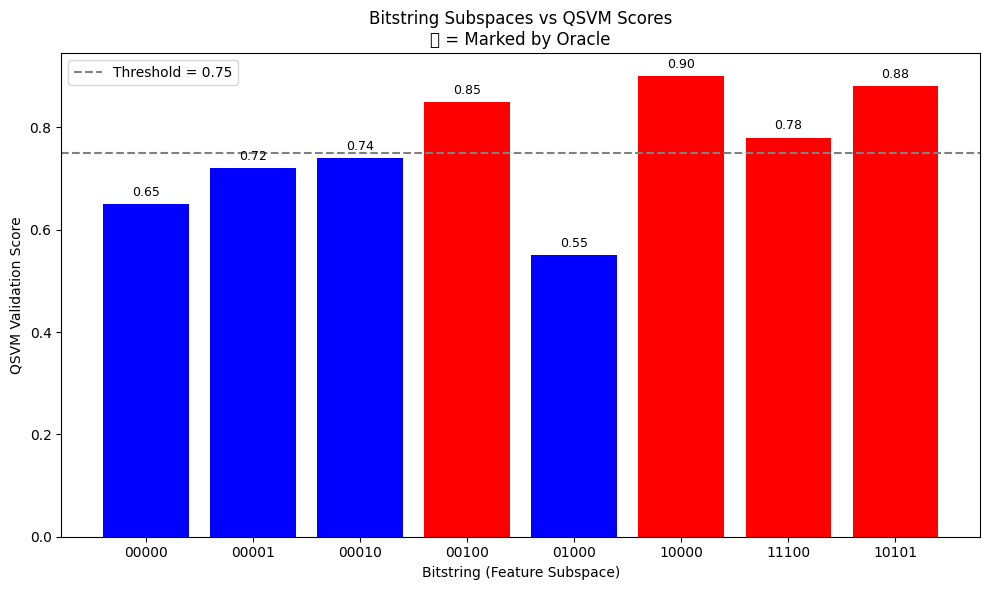

In [5]:
import matplotlib.pyplot as plt

# Example data — replace with your actual bitstring scores
bitstrings = ['00000', '00001', '00010',
              '00100', '01000', '10000', '11100', '10101']
scores = [0.65, 0.72, 0.74, 0.85, 0.55, 0.90, 0.78, 0.88]

# Define oracle threshold
threshold = 0.75
marked = [score >= threshold for score in scores]

# Colors: red if marked by oracle, blue otherwise
colors = ['red' if m else 'blue' for m in marked]

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(bitstrings, scores, color=colors)

# Add score values on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01, f"{scores[i]:.2f}",
             ha='center', va='bottom', fontsize=9)

# Labels and title
plt.axhline(threshold, color='gray', linestyle='--',
            label=f'Threshold = {threshold}')
plt.xlabel("Bitstring (Feature Subspace)")
plt.ylabel("QSVM Validation Score")
plt.title("Bitstring Subspaces vs QSVM Scores\n🔴 = Marked by Oracle")
plt.legend()
plt.tight_layout()
plt.show()